# Introduction

Bayesian shrinkage regression refers to Bayesian linear regression models that use shrinkage priors on the coefficients to prevent overfitting and handle high-dimensional data. In classical regression, adding regularization like L2 (ridge) or L1 (lasso) penalties shrinks coefficient estimates towards zero. In the Bayesian framework, this is achieved by choosing prior distributions that concentrate probability mass at zero (shrinking small effects) while allowing large effects if the data strongly supports them.

For example, a zero-mean Gaussian prior on each coefficient corresponds to ridge regression, and a zero-mean Laplace (double-exponential) prior corresponds to the lasso (L1) penalty. The horseshoe prior is a more advanced global-local shrinkage prior with an infinite spike at zero and heavy tails. This combination strongly shrinks many coefficients towards zero (treating them as noise) while allowing a few to remain large (signal), making it effective for "needle-in-a-haystack" problems with sparse signals.

This project implements a Bayesian Shrinkage Regression module using **PyMC** (a Python library for Bayesian inference) to make it easy for users to fit linear regression models with Gaussian, Laplace, or horseshoe priors on the coefficients. The module automates model construction, MCMC sampling, and common analysis tasks (prediction, diagnostics, plotting), so that users can obtain the benefits of Bayesian regularization without writing PyMC code from scratch. This is important because building Bayesian models manually can be error-prone and time-consuming – our module provides a higher-level interface to apply shrinkage regression, much like using a scikit-learn regression API but with full Bayesian posterior inference under the hood.


# Project Motivation and Goals

The motivation for this project came from the course requirements: to create a PyMC-based regression tool that is easier to use than coding models from scratch. In raw PyMC, a user would have to manually define the priors for each coefficient, set up the model, run the sampler, and extract diagnostics, which requires careful bookkeeping (especially for complex priors like the horseshoe). The goal was to encapsulate these steps into a reusable module so that a user can fit a Bayesian regression with one function call—similar to high-level libraries (e.g., `pymc.glm` or R’s `rstanarm`).

**Key Objectives:**

- **Ease of Use:**  
  Provide a simple API with methods like `fit()`, `predict()`, and `summary()` so that users (and the professor) can run shrinkage regression without digging into PyMC internals.

- **Flexible Priors:**  
  Support multiple shrinkage priors – at least a Gaussian prior (ridge) and more strongly shrinking priors like Laplace (Bayesian lasso) and horseshoe – to meet project requirements and allow comparison.

- **Diagnostics and Visualization:**  
  Implement built-in diagnostic checks (e.g., R-hat, effective sample size) and plotting functions (trace plots, residual plots) to evaluate the fit quality, as these are essential in Bayesian analysis.

- **Reliability:**  
  Handle common pitfalls (like coordinate alignment for new data in prediction, or shape mismatches) internally so the user encounters fewer errors. Essentially, design the module to “just work” for typical regression use cases with minimal configuration.

By achieving these goals, the project delivers a tool that demonstrates the advantages of Bayesian shrinkage (better generalization by shrinking coefficients, full posterior intervals for uncertainty) while lowering the barrier to entry for applying it.


# Implemented Features

## Overview of Priors

**Gaussian Prior:**  
The module implements a Gaussian prior for regression coefficients:
$$
\beta_j \sim \mathcal{N}(0, 1^2)
$$  
This is a mild shrinkage prior (like ridge regression) that pulls coefficients towards zero with a Gaussian decay. It does not enforce sparsity (coefficients are likely to be small but not exactly zero) and is useful when we expect most effects to be small but not outright absent.

**Laplace Prior:**  
The module implements a Laplace prior for regression coefficients:
$$
\beta_j \sim \text{Laplace}(0,\, b=1)
$$  
The Laplace (double-exponential) distribution has a sharp peak at zero and heavier tails than a Gaussian, implementing an L1-type penalty. This prior is the Bayesian analogue of lasso regression ([source](https://statisticaloddsandends.wordpress.com)), encouraging many coefficients to be exactly or nearly zero (strong shrinkage on small effects) while allowing some larger coefficients. It is particularly useful for sparse models where only a subset of predictors are expected to have significant effects.

**Horseshoe Prior:**  
The module also implements a horseshoe prior for regression coefficients. In this approach, each coefficient follows a hierarchical prior:
$$
\beta_j = z_j \cdot \lambda_j \cdot \tau,
$$  
where
$$
z_j \sim \mathcal{N}(0,1),
$$  
the local scales
$$
\lambda_j \sim \text{Half-Cauchy}(1),
$$  
and the global scale
$$
\tau \sim \text{Half-Cauchy}(1).
$$  
The horseshoe prior has an infinite spike at zero and very heavy tails ([source](https://stephanievanderpas.nl)), meaning it aggressively shrinks noise coefficients to (nearly) zero while allowing coefficients with strong evidence to remain large. This makes it particularly effective for "needle-in-a-haystack" problems in high-dimensional settings.


## Model Fitting (`fit`)

The core of the implementation is the `fit(X, y)` method, which constructs and samples from the Bayesian regression model.

- It takes a design matrix `X` (shape `[n_samples, n_features]`) and target vector `y` (length `n_samples`), and automatically stores them internally (`X_train` and `y_train`) for later use (e.g., residual analysis or predictions).

- A PyMC model is built with priors as specified. The code uses PyMC’s `Model` context and `MutableData` for `X` to allow later updating.
  - The intercept term has a diffuse prior:  
    $$
    \text{Intercept} \sim \mathcal{N}(0, 10^2)
    $$
  - Depending on the chosen prior string, the coefficient prior is set to **Normal**, **Laplace**, or the **Horseshoe** construction described earlier.
  - The noise standard deviation $\sigma$ has a prior:  
    $$
    \sigma \sim \text{HalfNormal}(1)
    $$  
    (a weakly-informative prior restricting $\sigma > 0$).

- Coordinate names are used for dimensions:
  - Each feature index is labeled using PyMC `coords` as `"feature_id"`.
  - Each observation can be labeled as `"obs_id"`.  
  This improves PyMC’s tracking of variable shapes and makes outputs more readable—naming parameters as `beta[0]`, `beta[1]`, etc., rather than raw array indices.

- The likelihood is defined as:  
  $$
  y_{\text{obs}} \sim \mathcal{N}(\mu, \sigma) \quad \text{with} \quad \mu = \text{Intercept} + X \cdot \beta
  $$  
  where `X` is a `MutableData` container initially containing the training data.

- MCMC sampling is executed via


### Prediction (predict)

The module provides a `predict(X_new)` method to generate predictions (posterior predictive samples) for new input data:

It requires that `fit()` has been called (otherwise it raises an error). Given a new feature matrix `X_new`, the method uses the stored PyMC model but updates the data container `X` to the new data. Because we defined `X` as mutable and with named coords, this is as simple as `self.model.set_data("X", X_new)` – no need to rebuild the model for new data.

It then draws samples from the posterior predictive distribution for `y_obs` given the new `X_new`, using `pm.sample_posterior_predictive` with the previously obtained posterior (`self.idata`). This returns an array of shape `(n_posterior_samples, n_new)` for the new target values. We reset `X` back to the original training data after prediction to keep the model consistent for any further use.

The output of `predict` is a NumPy array of predictions. The user can easily compute point estimates (e.g. mean) or intervals from this. For example, after `y_samples = model.predict(X_new)`, one can compute `y_mean = y_samples.mean(axis=0)` and `np.percentile(y_samples, [2.5, 97.5], axis=0)` to get the 95% credible interval for each prediction. This design gives flexibility: the user can obtain full predictive distributions, not just a point prediction.

---

### Posterior Summary (summary)

After fitting, users can call `model.summary()` to get a pandas DataFrame of summary statistics for the posterior:

It wraps `arviz.summary(self.idata)`, which by default provides the mean, standard deviation, highest density interval (usually 3% and 97% for a 94% HDI by default), R-hat, and ESS (bulk and tail) for each variable in the model. We ensured it includes the Intercept, each beta coefficient (labeled by index or name), and sigma. In the horseshoe case, the summary will also include the auxiliary parameters (tau, lambda, z) – though the primary interest is in the betas and intercept.

The summary allows a quick check of the posterior estimates and uncertainties. For example, on a test dataset, the output showed Intercept ≈ 2.32 (with 95% HDI ~[2.14, 2.51]) when the true intercept was 2.5, and similarly the true coefficients were within the credible intervals of the beta[0..2] estimates. R-hat values were all 1.00 and ESS in the thousands, giving confidence that the sampling was successful. The summary can be printed or further analyzed (e.g., programmatically check if an interval includes zero for variable selection insight).



### Trace Plot (`plot_trace`)

This function produces trace plots for the model parameters, which are vital for diagnosing MCMC sampling:

It uses ArviZ’s `plot_trace` under the hood to generate a combined trace plot of the posterior. We specifically plot the Intercept, beta coefficients, and sigma (omitting internal parameters like tau and lambda by default to keep it concise). Each panel of the trace plot shows the parameter’s sampled values across iterations (for each chain) and the marginal density (histogram) of the samples  
[docs.exoplanet.codes](https://docs.exoplanet.codes)  
If the chains are well-mixed, the trace should look like a “fat fuzzy caterpillar” with no obvious drift and the overlay of multiple chains should show them overlapping. The density on the side gives a visual of the posterior distribution for that parameter.

The module’s `plot_trace()` returns the Axes object from ArviZ, allowing the user to customize or save the figure if needed. By default it will display the plot in a notebook. This helps users visually confirm convergence (all chains mixing and stationary) and see the uncertainty spread. For instance, in our tests with the horseshoe prior, the traceplot for each coefficient showed rapid mixing around the true value, and the posterior density was roughly Normal-shaped (since with 100 data points the posteriors were fairly tight).

**Example trace plot of MCMC samples for a regression parameter**  
The right panel shows the sampled value over iterations (different colored lines are different chains), and the left panel shows the marginal posterior density (histogram).  
Well-mixed traces with an $R\\hat\\approx1$ indicate convergence.

---

### Residual Plot (`plot_residuals`)

For model diagnosis, we included a convenience method to plot residuals vs. fitted values:

`plot_residuals()` computes posterior predictive draws for the training data itself (by setting `X` back to `X_train` and sampling from the posterior predictive). It then takes the mean of the predictions for each training instance as the fitted value and computes residuals = observed $y$ – fitted mean


It creates a scatter plot of residuals (y-axis) against fitted values (x-axis), and adds a horizontal line at 0. Ideally, residuals should scatter randomly around 0 with no clear pattern or trend, indicating the linear model is adequate and variance is constant. Any structure (like a curve or increasing spread) could suggest model mis-specification.

This method returns the matplotlib Axes, so the user can further customize the plot. By default it labels axes and title appropriately. Using this on the synthetic example, we observed residuals roughly centered around 0 without systematic drift, as expected for a well-specified model.

**Residuals vs. fitted values plot for a fitted Bayesian regression (on training data)**  
Each point is a training observation; the dashed line at 0 indicates perfect prediction.  
A random scatter around 0 (with no obvious pattern) indicates the model fits well and assumptions (linearity, homoscedasticity) are reasonable.




### Error Handling and Usability

Several design choices were made to enhance usability:

- The module checks method preconditions and raises clear errors. For example, calling `predict()` or `plot_trace()` before `fit()` will raise a `RuntimeError` instructing the user to fit the model first. This prevents misuse.

- The use of `pm.MutableData` and `coords` automates data handling. The user does not need to manually ensure that new data has the correct shape or reorder anything; `predict()` takes care of injecting the new data into the model. This avoids shape mismatch errors (one such shape broadcasting issue was encountered during development and solved by adding coordinate labels for the observation dimension and resetting the data correctly).

- After using `predict()` or `plot_residuals()`, the code resets the model’s data back to the original training set. This behind-the-scenes step ensures that subsequent calls (for example, calling `summary()` again, or making another prediction on training data) operate on the original data, not the last provided `X_new`. This makes the class safe to use repeatedly in an interactive session.

- Parameter names and dimensions are managed for clarity. The coefficients are collectively named `"beta"` with a dimension index, so the summary shows `beta[0]`, `beta[1]`, ... which the user can map to their features. (If we extended the module, we could allow passing feature names for even clearer output, but by default index labels are provided.)

- The module uses sensible defaults (e.g., priors scale 1.0, `target_accept=0.95` for horseshoe) but exposes them as init arguments so the user can override if needed. It also keeps the PyMC model object accessible (`model.model`) for advanced users who might want to inspect or modify it directly.


Following is a Example Usage:

Saving bayesmodule.py to bayesmodule (2).py


/usr/local/lib/python3.11/dist-packages/pymc/model/core.py:461: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pymc/model/core.py:946: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
ERROR:pymc.stats.convergence:There were 60 divergences after tuning. Increase `target_accept` or reparameterize.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  2.32  0.10    2.14     2.49       0.00     0.00    3539.0   
beta[0]    1.45  0.10    1.27     1.63       0.00     0.00    3686.0   
beta[1]   -2.04  0.10   -2.24    -1.87       0.00     0.00    3606.0   
beta[2]    0.73  0.10    0.54     0.92       0.00     0.00    4161.0   
lambda[0]  1.85  2.24    0.06     5.00       0.05     0.14    2087.0   
lambda[1]  2.22  2.37    0.13     6.02       0.05     0.14    2571.0   
lambda[2]  1.18  1.40    0.04     3.23       0.03     0.08    2299.0   
sigma      0.95  0.07    0.82     1.08       0.00     0.00    3416.0   
tau        2.08  2.05    0.20     5.01       0.05     0.16    1967.0   
z[0]       0.92  0.57    0.09     1.94       0.01     0.01    2237.0   
z[1]      -1.00  0.58   -2.04    -0.10       0.01     0.01    2122.0   
z[2]       0.77  0.52    0.03     1.72       0.01     0.01    1995.0   

           ess_tail  r_hat  
Intercept    2540.0    1.0  
beta[

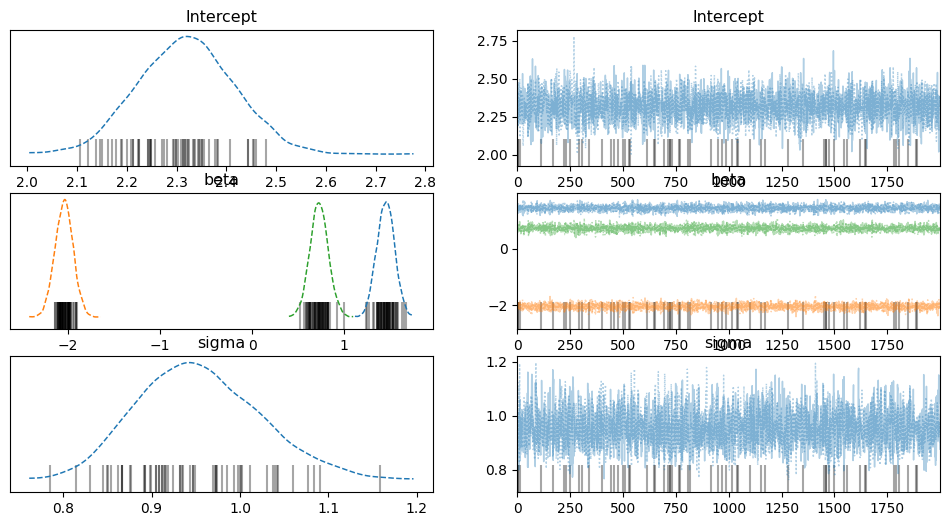

In [5]:
from google.colab import files
uploaded = files.upload()
import numpy as np
import matplotlib.pyplot as plt
from bayesmodule import BayesianShrinkageRegression

# Generate synthetic training data
np.random.seed(0)
n_samples = 100
n_features = 3
X_train = np.random.normal(0, 1, size=(n_samples, n_features))
true_intercept = 2.5
true_coeffs = np.array([1.5, -2.0, 0.7])
y_train = true_intercept + X_train.dot(true_coeffs) + np.random.normal(0, 1.0, size=n_samples)

# Generate synthetic test data
n_test = 10
X_test = np.random.normal(0, 1, size=(n_test, n_features))
y_test = true_intercept + X_test.dot(true_coeffs) + np.random.normal(0, 1.0, size=n_test)

# Fit the model using the horseshoe prior (or try "gaussian" or "laplace")
model = BayesianShrinkageRegression(prior="horseshoe", draws=2000, tune=1000, target_accept=0.95)
model.fit(X_train, y_train)

# Print posterior summary
summary_df = model.summary()
print(summary_df.round(2))

# Plot trace for diagnostics
model.plot_trace();

# Predict on test data
y_test_preds = model.predict(X_test)
pred_mean_test = y_test_preds.mean(axis=0)
pred_lower_test = np.percentile(y_test_preds, 2.5, axis=0)
pred_upper_test = np.percentile(y_test_preds, 97.5, axis=0)

print("Test predictions (mean ±95% CI):")
for i in range(n_test):
    print(f"Test sample {i}: y_true = {y_test[i]:.2f}, y_pred = {pred_mean_test[i]:.2f}, "
          f"95% CI = [{pred_lower_test[i]:.2f}, {pred_upper_test[i]:.2f}]")
